In [16]:
%load_ext autoreload
%autoreload 2
import importlib

from pysentimiento.hate import load_datasets as load_hate
from pysentimiento.tass import load_datasets as load_sentiment
from pysentimiento.emotion import load_datasets as load_emotion
from pysentimiento.irony import load_datasets as load_irony
from transformers import AutoTokenizer

tasks = {
    "hate": load_hate,
    "sentiment": load_sentiment,
    "emotion": load_emotion,
    "irony": load_irony,
}

tokenizers = {
    "beto_uncased" : AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased"),
    "beto_cased" : AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased"),
    "roberta" : AutoTokenizer.from_pretrained("BSC-TeMU/roberta-base-bne"),
    "bertin" : AutoTokenizer.from_pretrained("bertin-project/bertin-roberta-base-spanish"),
    "robertuito_cased" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-cased"),
    "robertuito_uncased" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased"),
    "robertuito_deacc" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-deacc"),
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd

df = pd.DataFrame()
for task, load_datasets in tasks.items():
    print(f"Task: {task}")
    splits = load_datasets(lang="es")
    dataset = pd.concat([x.to_pandas() for x in splits])
    dataset["task"] = task.upper()
    df = pd.concat([df, dataset.loc[:, ["text", "task"]]])

INFO:pysentimiento:Train path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_train.csv
INFO:pysentimiento:Dev path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_dev.csv
INFO:pysentimiento:Test path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_test.csv


Task: hate
Task: sentiment
4802 2443 7264
Task: emotion
Task: irony


In [20]:
# Les resto 2 por los tokens iniciales y finales

args = {
    "truncation": True,
    "max_length": 128,
}

for tok_name, tokenizer in tokenizers.items():
    df[tok_name] = [sum(x) - 2 for x in tokenizer(list(df["text"].values), **args)["attention_mask"]]

FileNotFoundError: [Errno 2] No such file or directory: 'img/length_tokens_full.pdf'

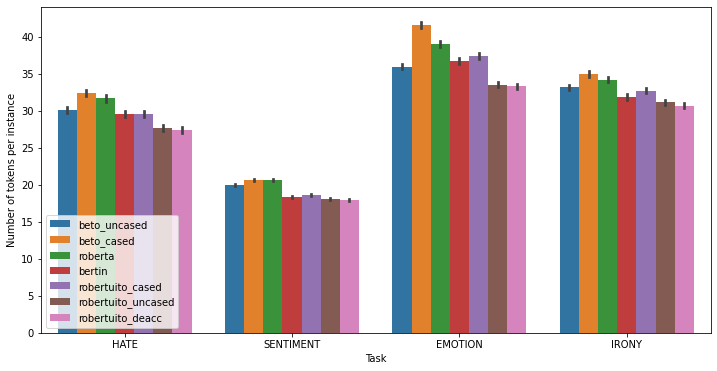

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

melted_df = df.melt(id_vars=["task"], value_vars=["beto_uncased", "beto_cased", "roberta", "bertin", "robertuito_cased", "robertuito_uncased", "robertuito_deacc"], var_name="tokenizer", value_name="length")

plt.figure(figsize=(12, 6))

sns.barplot(x="task", y="length", hue="tokenizer", data=melted_df, ci=95)

plt.xlabel("Task")
plt.ylabel("Number of tokens per instance")
plt.legend(loc="lower left")
plt.savefig("img/length_tokens_full.pdf", bbox_inches="tight")

In [38]:
mean_df = melted_df.groupby(["task", "tokenizer"]).mean().sort_values(by="length").round(2)
std_df = melted_df.groupby(["task", "tokenizer"]).std().sort_values(by="length").round(1)

std_df

length
task      tokenizer                 
SENTIMENT robertuito_deacc       7.6
          robertuito_uncased     7.6
          robertuito_cased       7.9
          bertin                 8.3
          beto_uncased           8.4
          roberta                8.4
          beto_cased             8.8
EMOTION   robertuito_deacc      16.3
          robertuito_uncased    16.4
HATE      robertuito_deacc      16.6
          robertuito_uncased    16.7
IRONY     robertuito_deacc      17.2
          robertuito_uncased    17.4
HATE      beto_uncased          17.5
EMOTION   robertuito_cased      17.7
          beto_uncased          17.7
HATE      robertuito_cased      17.9
          roberta               18.1
          bertin                18.1
IRONY     beto_uncased          18.1
          robertuito_cased      18.2
HATE      beto_cased            19.1
EMOTION   bertin                19.1
IRONY     bertin                19.2
          roberta               19.3
EMOTION   roberta               19.4
IRONY     beto_cased            19.5
EMOTION   beto_cased            19.7

In [39]:
pepe_df = mean_df.astype(str) + " ± " + std_df.astype(str)

pepe_df.unstack(0)

length                                         
task                     EMOTION          HATE         IRONY    SENTIMENT
tokenizer                                                                
bertin              36.68 ± 19.1  29.56 ± 18.1  31.87 ± 19.2  18.33 ± 8.3
beto_cased          41.55 ± 19.7   32.4 ± 19.1  34.92 ± 19.5  20.66 ± 8.8
beto_uncased        35.94 ± 17.7  30.06 ± 17.5  33.14 ± 18.1  19.95 ± 8.4
roberta             39.02 ± 19.4  31.67 ± 18.1  34.21 ± 19.3  20.68 ± 8.4
robertuito_cased    37.33 ± 17.7  29.51 ± 17.9  32.71 ± 18.2  18.64 ± 7.9
robertuito_deacc    33.31 ± 16.3  27.39 ± 16.6   30.7 ± 17.2  17.92 ± 7.6
robertuito_uncased   33.5 ± 16.4   27.7 ± 16.7  31.12 ± 17.4  18.08 ± 7.6